In [1]:
import sys
import yaml
import numpy as np
import pandas as pd
import PIL
import pydicom
import tensorflow as tf
import keras

# hint: notebook is executed in jupyter lab dark mode
%matplotlib inline
import matplotlib.pyplot as plt
# see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html for styles
plt.style.use('dark_background')
# global color settings (use white/grey for jupyterlab dark mode
# and black/grey for jupyterlab light mode)
COLOR = 'grey'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
# plt.rcParams['grid.color'] = COLOR
# plt.rcParams['figure.edgecolor'] = 'red'
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Pandas version: {pd.__version__}')
print(f'Tensorflow version: {tf.__version__}')

# the following code snippet is necessary for tensorflow training to work (tf2.2, cuda10.2 or 10.1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)

Python version: 3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]
Numpy version: 1.18.1
Pandas version: 1.0.3
Tensorflow version: 2.2.0


Using TensorFlow backend.


In [2]:
## location to save the models
PATH_MODEL = 'models/model1/'

In [3]:
with open(f'{PATH_MODEL}config_parameters.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    lst = yaml.load(file, Loader=yaml.FullLoader)
dict_cfg_paths, dict_cfg_rand, dict_cfg_model, dict_cfg_data = lst

In [16]:
def check_dicom(dcm):
    """
    Checks dicom metadata header for important fields of the
    implemented model and raises NotImplementedError if the
    dicom file has unmaching parameters.
    :param dcm: dicom file
    :return: None
    """
    ## check proper image acquisition type:
    if not dcm.Modality.lower() in ['dx']:
        txt = (f"{dcm.Modality} is not a valid image acquisition type. " + 
               "The trained model only works on 'dx' images.")
        raise NotImplementedError(txt)

    ## check proper image body part:
    if not dcm.BodyPartExamined.lower() in ['chest']:
        txt = (f"{dcm.BodyPartExamined} is not a valid body part. " +
               "The trained model only works on chest x-ray images.")
        raise NotImplementedError(txt)

    ## check proper patient position/ image acquisition orientation
    if not dcm.PatientPosition.lower() in ['pa', 'ap']:
        txt = (f"{dcm.PatientPosition} is not a valid image orientation. " +
               "The trained model only works on viewing positions 'ap' and 'pa'.")
        raise NotImplementedError(txt)

        
def import_dicom(filename, perform_check=True, print_metadata=False):
    """
    This function reads in a .dcm file, checks for relevant parameters (optional) and returns the image data
    :param filename: path to dicom file
    :param perform_check: boolean, set true to check the important fields (metadata) of the implemented model
    :param print_metadata: boolean, if true print all relevant dicom metadata
    :returns: returns a numpy array of just the imaging data
    """
    print(f'Load file {filename} ...')
    ## import dicom image
    dcm = pydicom.dcmread(filename)
    
    if perform_check:
        check_dicom(dcm)
    
    if print_metadata: 
        print(f'PID: {dcm.PatientID}')
        print(f'Patient sex: {dcm.PatientSex}')
        print(f'Patient age: {int(dcm.PatientAge)}')
        print(f'Patient position: {dcm.PatientPosition}')
        print(f'Examined body part: {dcm.BodyPartExamined}')
        print(f'Modality: {dcm.Modality}')
        print(f'Findings: {dcm.StudyDescription}')
        print(f'image dimensions: {dcm.Rows} x {dcm.Columns}')
        print()
    
    # get image data (np array)
    img = dcm.pixel_array
    return img


def dicom_label(filename: str) -> str:
    """
    Extract label of dicom file
    :param filename: path to dicom file
    :return: dicom label (string)
    """
    dcm = pydicom.dcmread(filename)
    return dcm.StudyDescription.lower().replace(' ', '_')


def dicom_pneumonia_label(filename: str) -> int:
    """
    Extract pneumonia label
    :param filename: path to dicom file
    :return: pneumonia label ({0, 1})
    """
    if dicom_label(filename=filename) in ('pneumonia'):
        return 1
    return 0


def preprocess_image(img: np.array, img_mean: float, img_std: float,
                     img_size: tuple, scale_type: str):
    """
    This function takes the numpy array output by import_dicom and 
    runs the appropriate pre-processing needed for our model input

    """
    img_pil = PIL.Image.fromarray(img)
    ## resize image:
    ## use nearest for intrpolation. this is used in keras as of June 2020
    ## nearest: Pick one nearest pixel from the input image. Ignore all other input pixels.
    proc_img = img_pil.resize(size=img_size, resample=PIL.Image.NEAREST)
    if not scale_type:
        proc_img = np.array(proc_img)
    elif scale_type.lower()=='standardization':
        proc_img = (np.array(proc_img) - img_mean) / img_std
    elif scale_type.lower()=='normalization':
        proc_img = np.array(proc_img) / 255.0
    else:
        raise NotImplementedError("Scaling type must be either 'standardization', 'normalization' or None")
    ## reshape image from grayscale to rgb and introduce batch dimension:
    proc_img = tf.image.grayscale_to_rgb(tf.reshape(proc_img, (1, *tuple(img_size), 1)))
    return proc_img.numpy()


def load_model(path_model, path_weights):
    """
    This function loads in the trained model with weights and compiles it 
    """
    model = keras.models.load_model(path_model, compile=False)
    model.load_weights(path_weights)
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh: float): 
    """
    Classify a (preprocessed) X-ray image based on the model threshold parameter
    to predict whether or not the image shows the presence of pneumonia

    """
    pred = model.predict(img, verbose=0)
    if pred[0][0] >= thresh:
        return 1
    else:
        return 0

In [17]:
dict_cfg_model

{'EPOCHS': 5,
 'IMG_SIZE': (224, 224),
 'INITIAL_LEARNING_RATE': 0.01,
 'MODEL_ARCHITECTURE': 'densenet121',
 'thresh': 0.5}

In [18]:
dict_cfg_data

{'BATCH_SIZE_TEST': 16,
 'BATCH_SIZE_TRAIN': 16,
 'BATCH_SIZE_VALID': 16,
 'DICT_AUGMENTATION': {'height_shift_range': 0.05,
  'horizontal_flip': True,
  'rotation_range': 5,
  'shear_range': 0.1,
  'vertical_flip': False,
  'width_shift_range': 0.1,
  'zca_whitening': False,
  'zoom_range': 0.15},
 'SCALE_TYPE': 'normalization',
 'data_mean': None,
 'data_std': None}

In [20]:
lst_test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = f'{PATH_MODEL}pneumonia_vgg16_model'
weight_path = f'{PATH_MODEL}weights/weights.hdf5'

IMG_SIZE = dict_cfg_model['IMG_SIZE']
img_mean = dict_cfg_data['data_mean']
img_std = dict_cfg_data['data_std']

my_model = load_model(path_model=model_path, path_weights=weight_path)
thresh = dict_cfg_model['thresh']

for i in lst_test_dicoms:
    try:
        img = import_dicom(i, perform_check=True, print_metadata=False)
    except NotImplementedError as e:
        print(e)
        continue
        
    img_proc = preprocess_image(img=img, img_mean=img_mean, img_std=img_std,
                                img_size=IMG_SIZE, scale_type=dict_cfg_data['SCALE_TYPE'])
    pred = predict_image(model=my_model, img=img_proc, thresh=thresh)
    label_dicom = dicom_label(filename=i)
    label_pneumonia = dicom_pneumonia_label(filename=i)
    print(f'model pneumonia prediction: {pred}, pneumonia label: ' +
          f'{label_pneumonia} (label dicom file: {label_dicom})')

Load file test1.dcm ...
model pneumonia prediction: 0, pneumonia label: 0 (label dicom file: no_finding)
Load file test2.dcm ...
model pneumonia prediction: 0, pneumonia label: 0 (label dicom file: cardiomegaly)
Load file test3.dcm ...
model pneumonia prediction: 0, pneumonia label: 0 (label dicom file: effusion)
Load file test4.dcm ...
RIBCAGE is not a valid body part. The trained model only works on chest x-ray images.
Load file test5.dcm ...
CT is not a valid image acquisition type. The trained model only works on 'dx' images.
Load file test6.dcm ...
XX is not a valid image orientation. The trained model only works on viewing positions 'ap' and 'pa'.


Load file test1.dcm ...
PID: 2
Patient sex: M
Patient age: 81
Patient position: PA
Examined body part: CHEST
Modality: DX
Findings: No Finding
image dimensions: 1024 x 1024



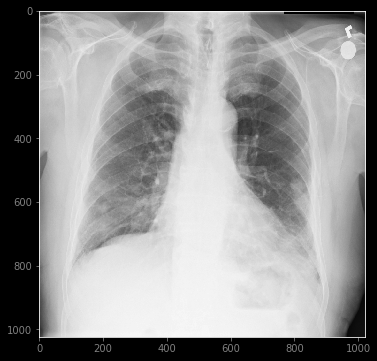

In [21]:
img_test = import_dicom(filename='test1.dcm', perform_check=False, print_metadata=True)
plt.imshow(img_test, cmap='gray')